### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler

### Get the data from Yahoo Finance

In [2]:
# Start and end dates are in YYYY-MM-DD format
data = yf.download(tickers = 'AAPL', start = '2014-08-30', end = '2024-08-30')
data.tail(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-16,223.919998,226.830002,223.649994,226.050003,226.050003,44340200
2024-08-19,225.720001,225.990005,223.039993,225.889999,225.889999,40687800
2024-08-20,225.770004,227.169998,225.449997,226.509995,226.509995,30299000
2024-08-21,226.520004,227.979996,225.050003,226.399994,226.399994,34765500
2024-08-22,227.789993,228.339996,223.899994,224.529999,224.529999,43695300
2024-08-23,225.660004,228.220001,224.330002,226.839996,226.839996,38677300
2024-08-26,226.759995,227.279999,223.889999,227.179993,227.179993,30602200
2024-08-27,226.000000,228.850006,224.889999,228.029999,228.029999,35934600
2024-08-28,227.919998,229.860001,225.679993,226.490005,226.490005,38052200


### Add Technical Indicators

In [3]:
# RSI
data['RSI'] = ta.rsi(data.Close, length=15) 
# Exponential Moving Average
data['EMAF'] = ta.ema(data.Close, length=20) # Fast Moving Average
data['EMAM'] = ta.ema(data.Close, length=100) # Medium Moving Average
data['EMAS'] = ta.ema(data.Close, length=150) # Slow Moving Average

### Add target for next closing price

In [4]:
data['TargetNextClose'] = data['Adj Close'].shift(-1)

### Cleanup

In [5]:
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

### Show the data with new columns

In [6]:
data_set = data.iloc[:, 0:9]
pd.set_option('display.max_columns', None)

data_set.tail(5)

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,TargetNextClose
2361,227.789993,228.339996,223.899994,224.529999,57.101556,221.445120,206.507854,200.413754,226.839996
2362,225.660004,228.220001,224.330002,226.839996,60.110704,221.958918,206.910470,200.763771,227.179993
2363,226.759995,227.279999,223.889999,227.179993,60.547126,222.456163,207.311847,201.113654,228.029999
2364,226.000000,228.850006,224.889999,228.029999,61.670425,222.987005,207.722107,201.470162,226.490005
2365,227.919998,229.860001,225.679993,226.490005,58.440513,223.320624,208.093749,201.801551,229.789993


### Scale features to between 0 and 1

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[0.04397607 0.04251968 0.04331526 ... 0.02625489 0.01659413 0.03456815]
 [0.04188475 0.04051327 0.042117   ... 0.02644527 0.01683098 0.03557302]
 [0.04188475 0.04072325 0.04174922 ... 0.02665781 0.0170827  0.03613827]
 ...
 [0.95457519 0.95357248 0.9563407  ... 0.99573355 0.99610226 0.96951517]
 [0.95102348 0.96089827 0.96108628 ... 0.99797213 0.9981223  0.96231317]
 [0.95999627 0.96561099 0.96483525 ... 1.         1.         0.97774604]]


In [8]:
X = []
# The number of historical candles used to predict
backcandles = 20
# Print number of rows in data_set_scaled
print(data_set_scaled.shape[0])
# Iterate through the first 8 columns to create time-series sequences based on last 10 candles
for j in range(8):
    # For each feature an empty list is appeneded to store the sequences
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        # Append the sequence of the last 'backcandles' candles for feature j
        X[j].append(data_set_scaled[i-backcandles:i, j])

# Change the shape of X from a 2D list structure to a 3D numpy array
X = np.moveaxis(X, [0], [2])

# X consists of the features
# yi is the TargetNextClose and it is the value we want to predict
X, yi = np.array(X), np.array(data_set_scaled[backcandles:, -1])
# Reshape y into 2D array where each entry represent single target value corresponding to each sequence in X
y = np.reshape(yi, (len(yi), 1))

print(X.shape)
print(y.shape)

2366
(2346, 20, 8)
(2346, 1)


### Split data into train test sets

In [9]:
# Time series data so we take first 80% of the data to use for training and 20% of the later data to use for testing
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

1876
(1876, 20, 8)
(470, 20, 8)
(1876, 1)
(470, 1)


### Create the model

In [10]:
model = Sequential()
model.add(Input(shape=(backcandles, 8)))
model.add(LSTM(150))
model.add(Dense(1, activation="linear"))

# We use Mean Absolute Error for metrics to see the model's prediction deviate from actual values
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150)            │        95,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,551 (373.25 KB)

 Trainable params: 95,551 (373.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [11]:
model.fit(X_train, y_train, batch_size=15, epochs=30, shuffle=True, validation_split=0.1)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0123 - mae: 0.0546 - val_loss: 9.9354e-04 - val_mae: 0.0255
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6886e-04 - mae: 0.0083 - val_loss: 9.0613e-04 - val_mae: 0.0242
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5047e-04 - mae: 0.0079 - val_loss: 0.0022 - val_mae: 0.0410
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5084e-04 - mae: 0.0081 - val_loss: 9.6581e-04 - val_mae: 0.0252
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3012e-04 - mae: 0.0078 - val_loss: 6.7677e-04 - val_mae: 0.0203
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2700e-04 - mae: 0.0072 - val_loss: 8.6798e-04 - val_mae: 0.0238
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5209e-04 - mae: 0.0083 - val_loss: 8.2787e-04 - val_mae: 0.0231
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2466e-04 - mae: 0.0073 - val_loss: 6.9042e-04 - val_mae: 0.0208


### Test the model

In [12]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[0.564206] [0.56180242]
[0.5587785] [0.5680006]
[0.56800246] [0.56850926]
[0.5746251] [0.56633535]
[0.57523686] [0.58428194]
[0.57503086] [0.59436525]
[0.5857112] [0.60773268]
[0.59573907] [0.59390284]
[0.6077014] [0.57285715]
[0.60272723] [0.62345905]


### Plot the price chart

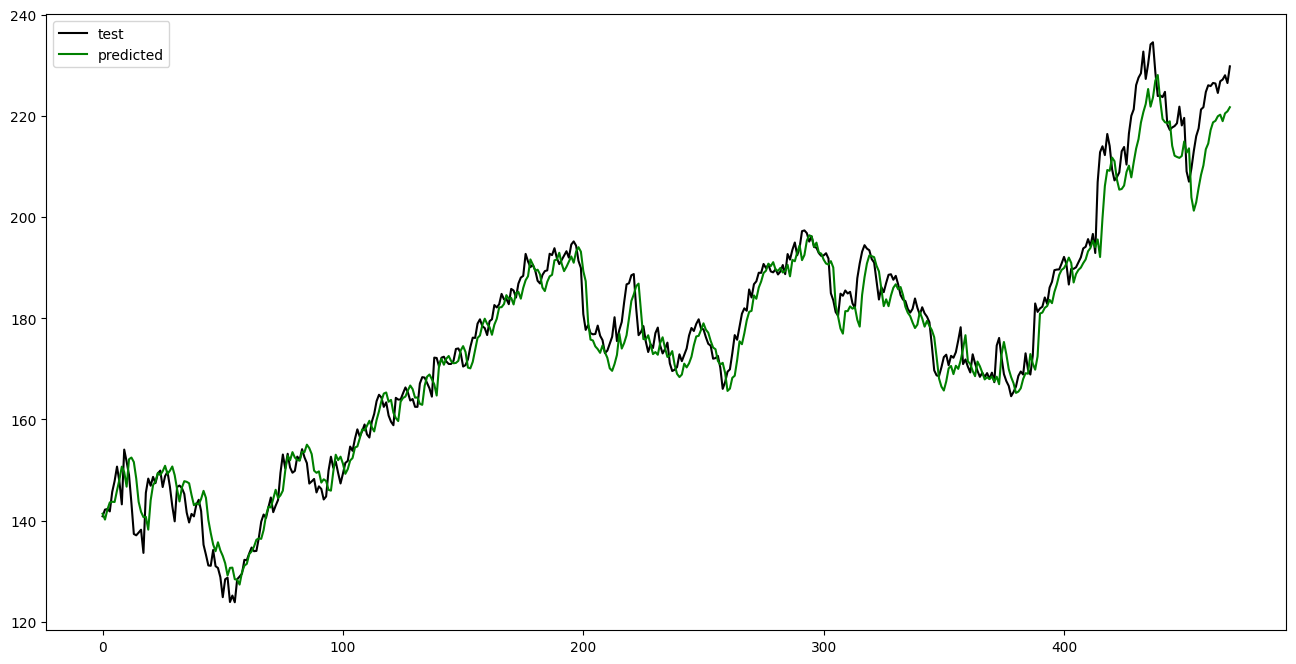

In [13]:
# Inverse transform predictions and actual values
y_pred_inverse = sc.inverse_transform(np.concatenate([X_test[:, -1, :], y_pred], axis=1))[:, -1]
y_test_inverse = sc.inverse_transform(np.concatenate([X_test[:, -1, :], y_test], axis=1))[:, -1]

plt.figure(figsize=(16, 8))
plt.plot(y_test_inverse, color='black', label='test')
plt.plot(y_pred_inverse, color='green', label='predicted')
plt.legend()
plt.show()